In [1]:
import pandas as pd

data_path = './data/'
metadata_dataframe = pd.read_csv('/ptbxl_database.csv')

In [2]:
sampling_rate = 500
ecg_id = 30
lead_index = 5


assert sampling_rate == 100 or sampling_rate == 500 ,  "Sampling rate must be one of 500 or 100"
assert isinstance(ecg_id, int), "ecg_id should be integer"
assert ecg_id >=1 and ecg_id <=21837, "ecg id should be between in range [1,21837]"
assert isinstance(lead_index, int), "lead_index should be integer"
assert lead_index >=0 and lead_index <=11, "lead_index should be between in range [0,11]"

In [3]:
import wfdb
import neurokit2 as nk

if sampling_rate == 100:
    ecg_file_name = metadata_dataframe.loc[metadata_dataframe['ecg_id'] == ecg_id, 'filename_lr'].values[0]
    data = wfdb.rdsamp(data_path+ecg_file_name)[0]
elif sampling_rate == 500:
    ecg_file_name = metadata_dataframe.loc[metadata_dataframe['ecg_id'] == ecg_id, 'filename_hr'].values[0]
    data = wfdb.rdsamp(data_path+ecg_file_name)[0]

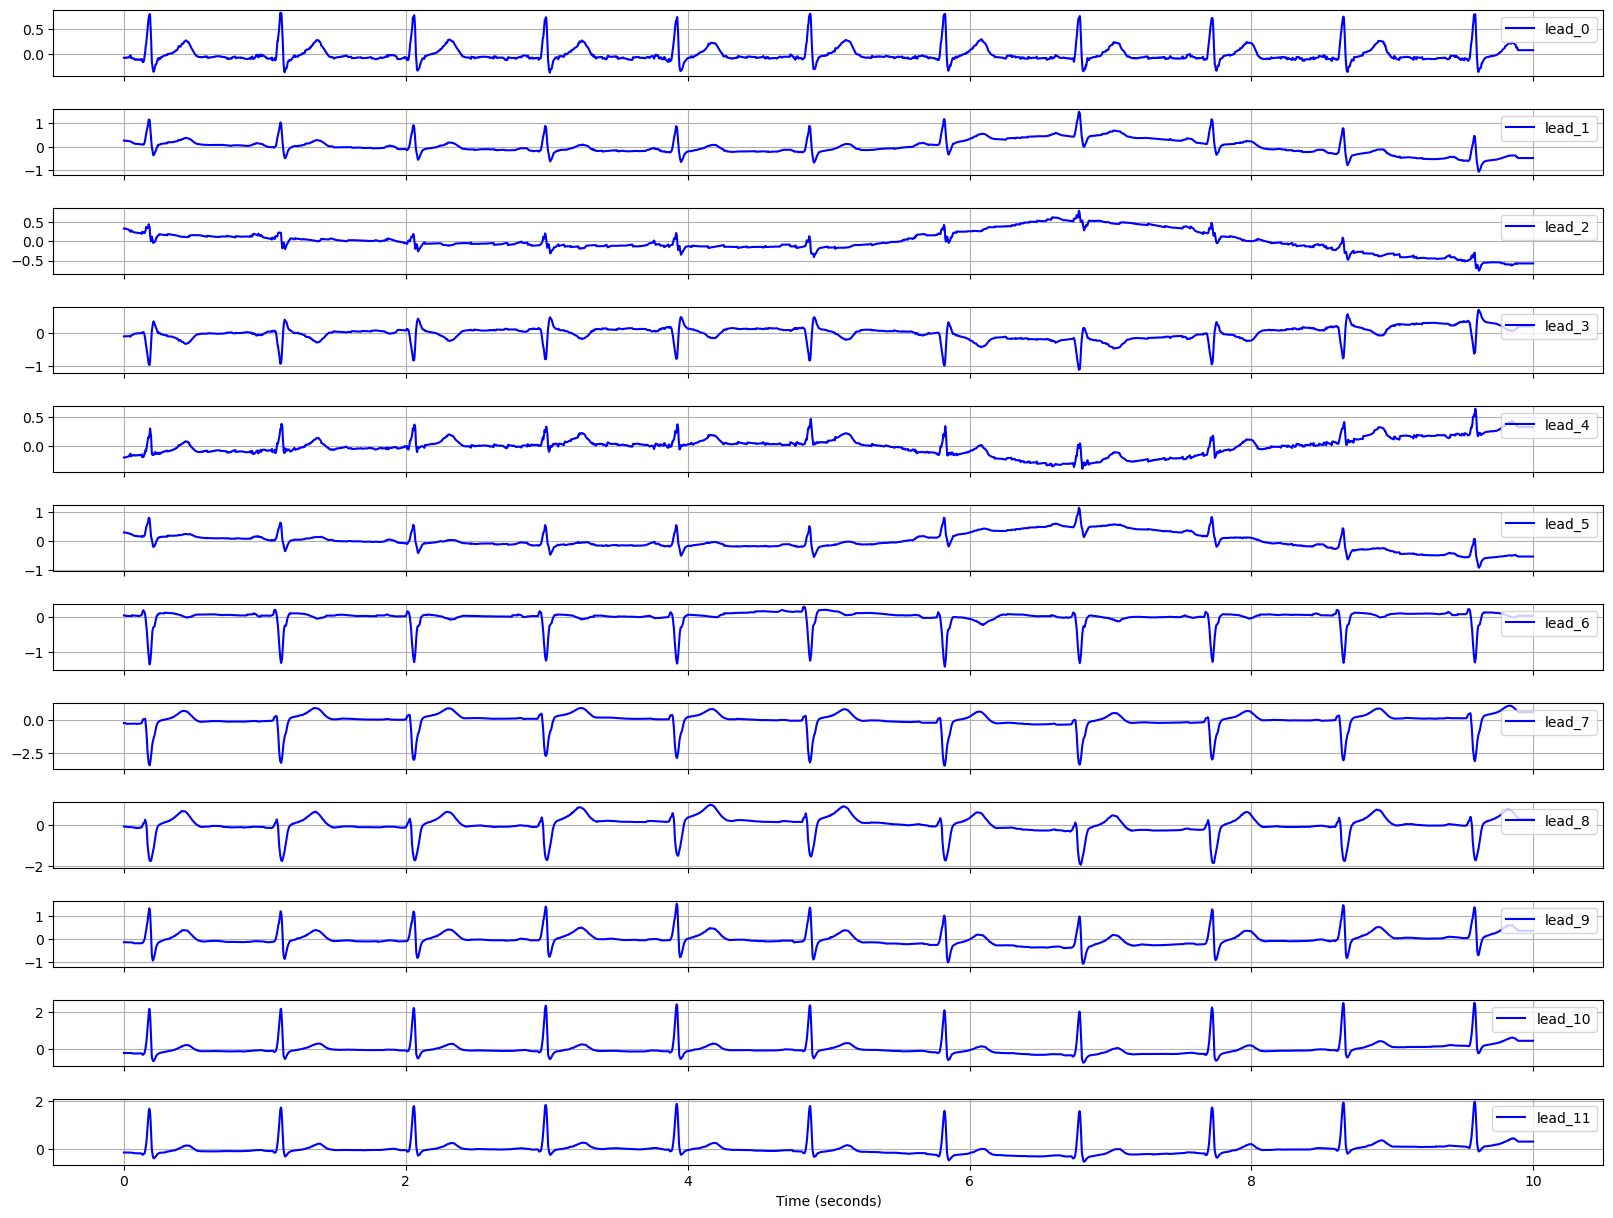

In [4]:
all_leadECG_records = pd.DataFrame({"lead_"+str(lead_dim): data[:,lead_dim] for lead_dim in range(data.shape[1])})
nk.signal_plot(all_leadECG_records, sampling_rate = sampling_rate, subplots = True)

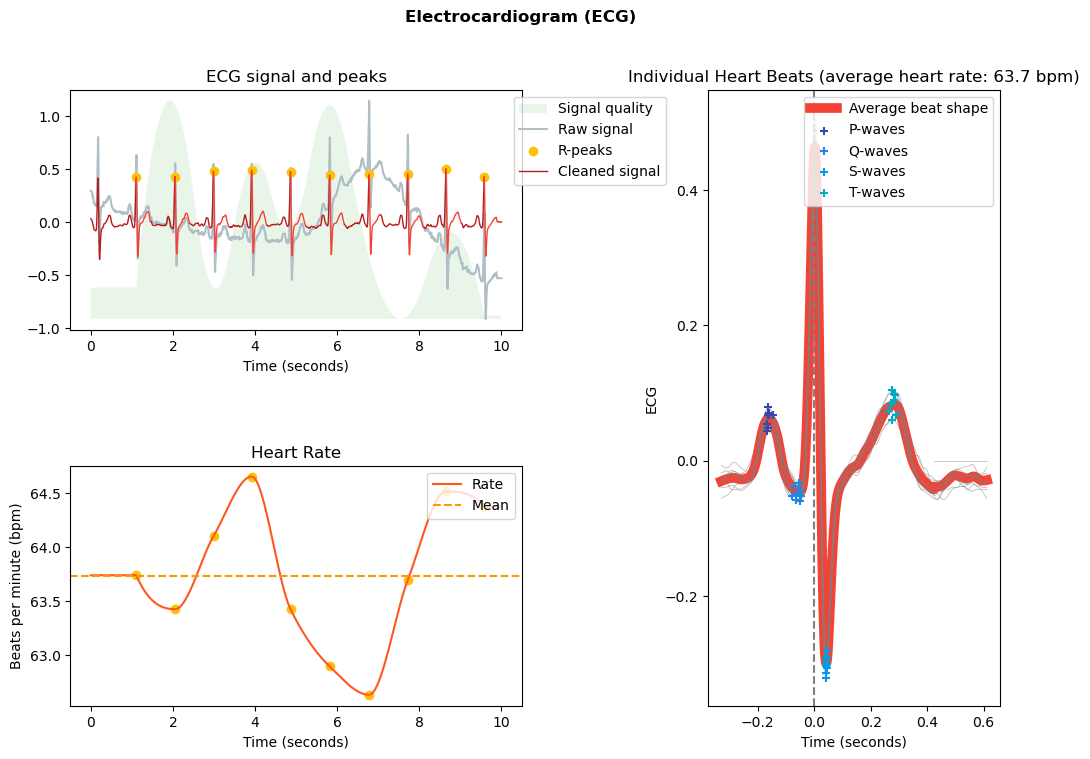

In [5]:
ecg = data[:,lead_index]
# Process it
signals, info = nk.ecg_process(ecg, sampling_rate=sampling_rate)
# Visualise the processing
nk.ecg_plot(signals, info)